In [2]:
import torch                            # main PyTorch package used for tensor computations and building deep learning models
import torch.nn as nn                   # contains a variety of predefined neural network layers (e.g., nn.Linear, nn.Conv2d). Provides loss functions (e.g., nn.CrossEntropyLoss). Tools to define the forward pass of models and train neural networks using backpropagation.
import numpy as np                      # fundamental package for scientific computing.
import matplotlib.pyplot as plt         # part of Matplotlib, a library used for creating static, interactive, and animated visualizations.
import os                               # os module provides a way to interact with the operating system in Python. Allows you to work with the file system, such as creating, deleting, and moving files or directories.
from PIL import Image                   # (Python Imaging Library). Supports opening, editing, and saving many image formats (e.g., PNG, JPEG). Provides image processing operations such as resizing, cropping, rotating, and applying filters to images.
from torchvision import transforms      # This is part of TorchVision, a library for working with image data. Provides a suite of transformations and augmentations for image preprocessing. Includes operations like resizing, normalizing, random cropping, flipping, and scaling images, which are crucial for preparing datasets for deep learning models.
import torchvision.models as models     # This module provides pretrained deep learning models like VGG16, ResNet, and others. You can load pretrained models, or create and fine-tune custom models based on architectures like VGG. These models are typically trained on large datasets like ImageNet, and you can either use them as feature extractors or fine-tune them for your specific tasks.

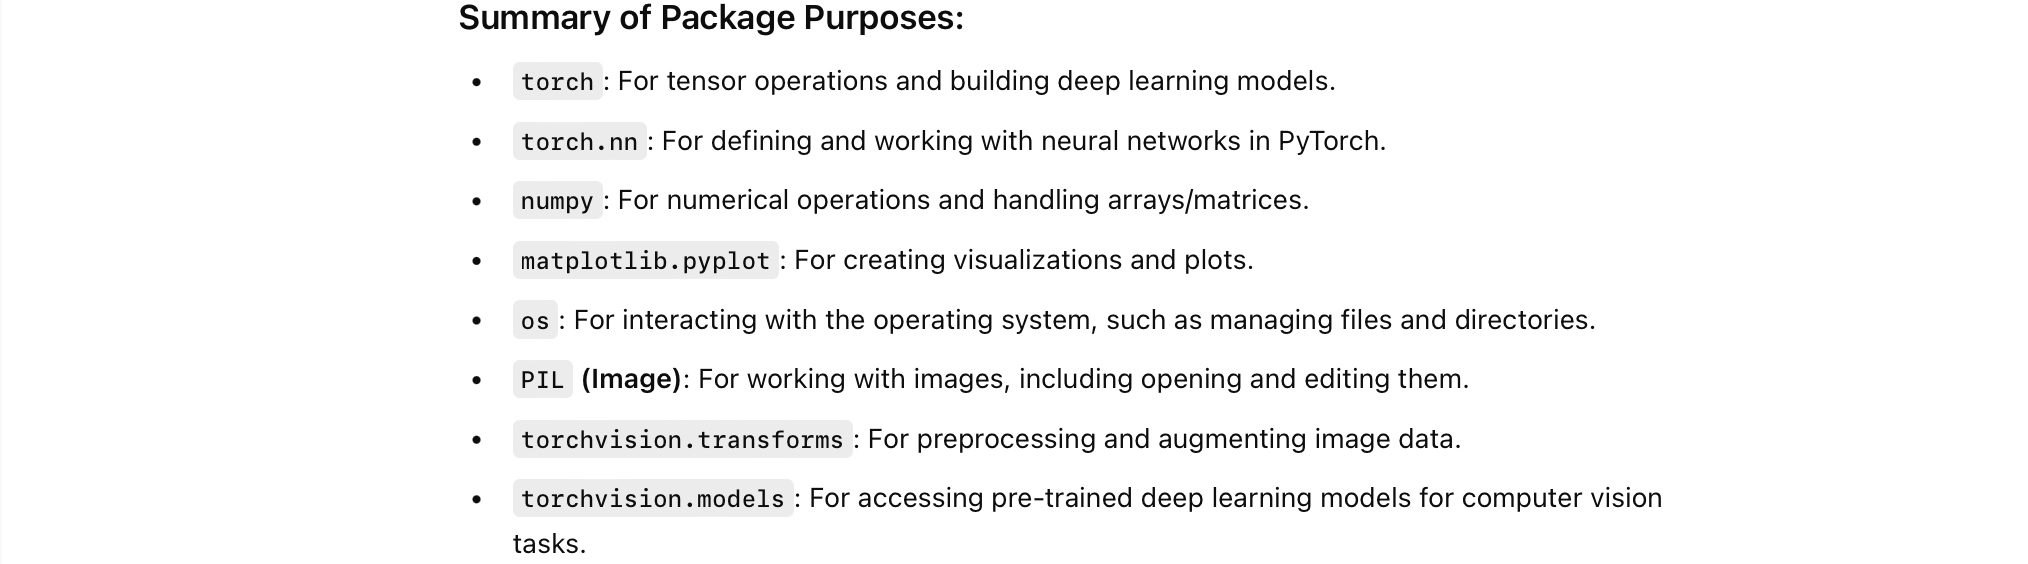

### Dataloader

In [3]:
def dataloader(path_dataset):
    images = []
    for filename in os.listdir(path_dataset):
        file_path = os.path.join(path_dataset, filename)
    
        with Image.open(file_path) as image:
            images.append(image.copy())
    number_of_images = len(images)
    return images, number_of_images


# In[5]:        # indicates the piece of code


#train
images_train_frac, num_frac_train = dataloader("Dataset/train/fractured")
images_train_notfrac, num_nofrac_train = dataloader("Dataset/train/not fractured")
num_images = num_frac_train + num_nofrac_train


# In[6]:


#validation
images_val_frac, num_frac_val = dataloader("Dataset/val/fractured")
images_val_notfrac, num_nofrac_val = dataloader("Dataset/val/not fractured")
num_images_val = num_frac_val + num_nofrac_val


# ### Transform images to tensors

# In[7]:
# This section of code is using TorchVision's transforms module to define a sequence of transformations to be applied to an image.
compressed_size = 224                             # defines the size to which the images will be resized. This is a common size in VGG. 
transform = transforms.Compose([                  # This is a container that chains together multiple image transformation operations. Each transformation is applied in sequence, one after the other, when the image is passed through this pipeline.
    transforms.Grayscale(),                       # Convert image to grayscale if not already. Grayscale refers to converting a colored image (with multiple color channels like RGB) into a black-and-white image, where each pixel represents a shade of gray rather than a color.
    transforms.Resize((compressed_size, compressed_size)),  # Resize image
    transforms.ToTensor(),                        # Convert to tensor and scale the pixel values from [0, 255] -> [0, 1]. Usually expects values in the [0, 1] range to handle the input correctly.
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize for grayscale. This normalizes the image by adjusting the pixel values based on the specified mean and std (standard deviation). Normalization helps to standardize the input and can improve the performance of the model. Here, the mean and standard deviation are set to [0.5], which is common for grayscale images.
])


# In[8]:


# In this snippet the "transform" defined above will be applied on these following images
transformed_images = []                            # This line initializes an empty list called transformed_images. This list will be used to store the images after they are transformed.
for image in images_train_frac:                    # This is a collection of the fractured images. The loop iterates over each image in this collection.
    transformed_images.append(transform(image))    # First the changes as "transform" are aplied to images, and after transforming the image, the transformed image is added to the transformed_images list using the append() method.
for image in images_train_notfrac:                 # This is a collection of the non-fractured images. The loop iterates over each image in this collection.
    transformed_images.append(transform(image))    # First the changes as "transform" are aplied to images, and after transforming the image, the transformed image is added to the transformed_images list using the append() method.
# append() is to add an item to the end of a list. Here every transformed image is added to the end of the list of either frac or not-frac lists. 


# In[9]:

# In this snippet the same is happening but with the "validation photos".
transformed_val_images = []
for image in images_val_frac:
    transformed_val_images.append(transform(image))
for image in images_val_notfrac:
    transformed_val_images.append(transform(image))

transforms.Normalize(mean=[0.5], std=[0.5])

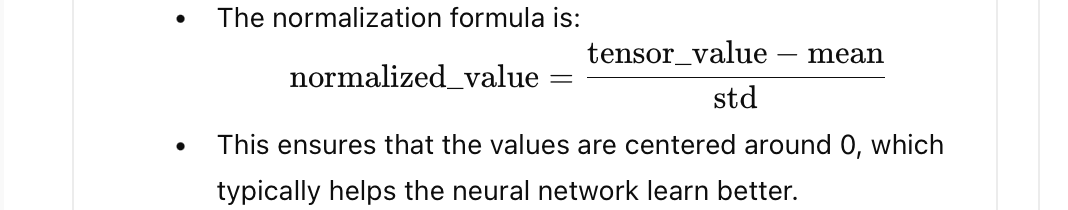

### Load model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the nn package to define our model and loss function.

model = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 32 kernels. dim in = 1* pic * pic, dimpot
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),

    nn.Dropout(0.825),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #64 kernels. dim in = pic/2 * pic/2 * 32
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),

    nn.Dropout(0.825),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128 kernels. dim in = 1* pic * pic, dimpot
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    
    nn.Dropout(0.825),
    

    nn.Flatten(), # dim = pic/4 * pic/4 * 64

    nn.Linear(in_features=100352, out_features=1),    # 1 fordi vi ønsker et tal mellem 0 og 1
    nn.Sigmoid(),
)
model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Dropout(p=0.825, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Dropout(p=0.825, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): ReLU()
  (14): Dropout(p=0.825, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=100352, out_features=1, bias=

### GradCAM

In [15]:
model.load_state_dict(torch.load("model_weights_63.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

C:\Users\45237\AppData\Local\Temp\ipykernel_12932\1591865465.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights_63.pth", map

<All keys matched successfully>

In [16]:
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Dropout(p=0.825, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Dropout(p=0.825, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): ReLU()
  (14): Dropout(p=0.825, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=100352, out_features=1, bias=

In [25]:
from torchcam.methods import GradCAM
input_image = transformed_images[549].unsqueeze(0)

model.eval()

with GradCAM(model, target_layer='10') as cam_extractor:
    # Preprocess your data and feed it to the model
    out = model(input_image)
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    if out>0.5:
        print('fractured')
    else:
        print('not fractured')

fractured


1069, 400 er ok, 1000 er underlig,

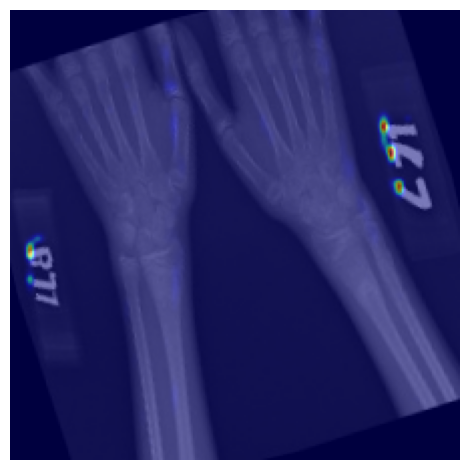

In [26]:
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
# Convert the input image (grayscale) to a PIL image with 3 channels
input_image = (input_image+1)/2  # Normalize fra [-1, 1] til [0, 1], for at kunne plotte det??
input_image_rgb = to_pil_image(input_image[0]).convert("RGB") # konverter billede til PIL-image med 3 kanaler så det kan plottes med det andet billede

activation_map_pil = to_pil_image(activation_map[0].squeeze(0), mode='F') # Convert the activation map to a PIL image

overlay = overlay_mask(input_image_rgb, activation_map_pil, alpha=0.5) 

plt.imshow(overlay); plt.axis('off'); plt.tight_layout(); plt.show()

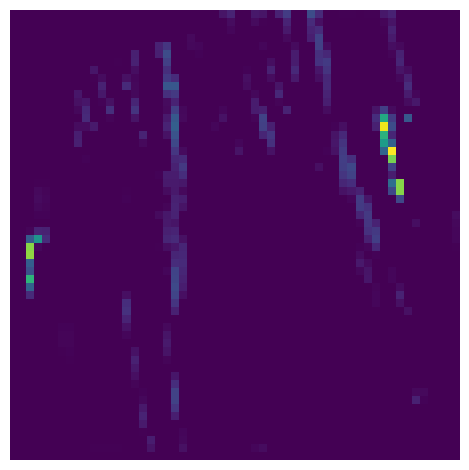

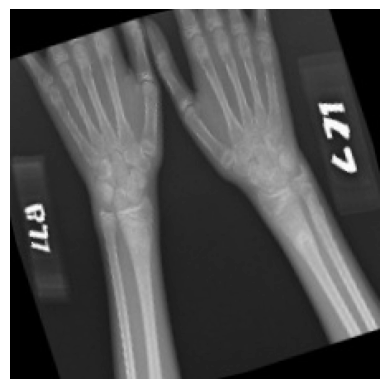

In [27]:
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

plt.figure()
plt.imshow(input_image[0][0].numpy(), cmap = 'gray')
plt.axis('off');